<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/T4_old_optimal_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import os
os.chdir('/content/drive/MyDrive/dynamic/T4old')

In [70]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 19 00:18:39 2021
Bo het historical NDI o droplist1a

@author: Administrator
"""

# from lstm_utils import *
import pickle
from sklearn.preprocessing import MinMaxScaler
####LIBRARY
import scipy
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras import Sequential

from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras # tai sao import tu tensorflow
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
# =============================================================================
# Import library
import os 
os.chdir('/content/drive/MyDrive/dynamic/T4old')
outs=['save_model_T4','save_pickle','table_T4','fig_T4']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
# =============================================================================
# -*- coding: utf-8 -*-
"""all_utils.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1ydQW-LmuXBguZbpvhMM2-LpdkVfdpRrg
"""

# !pip install -q -U keras-tuner --q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

####LIBRARY
import scipy
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras import Sequential, optimizers, backend
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras # tai sao import tu tensorflow
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# ROC
import datetime
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import datetime
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# import statsmodels as sm
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib
###  SET FONTS FOR PLOTTING
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
### cap nhat font
# plt.rcParams.update({'font.size': 14})

####RANDOM SEED SET
#tf.random.set_seed(10000000)
#np.random.seed(10000000)

####PANDAS LIB
from pandas import DataFrame
from pandas import concat
###### Univrate LSTM
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
######## Keras tunner
# import keras_tuner as kt

################################################
# CUSTOMIZE FUNCTION
# generate sample data by pandas shift
 ####cutomized sub.
def series_to_supervised_df(data, n_in, n_out, dropnan=True): # dung cho pandas
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

  # SAMPLE GENERATE

# CREATE A DATA INPUT FOR MODEL
#####################################################
def generate_input_M1(dataset,dataset_climate,k0,n_in0,n_out0):
  # n_window0=5
  dataset0=dataset[k0]
  dataset0_climate=dataset_climate[k0]
  df_supervised0=series_to_supervised_df(dataset0,n_in=n_in0,n_out=n_out0)

  df_supervised0_climate=series_to_supervised_df(dataset0_climate,n_in=n_in0,n_out=n_out0)

  # thang df_supervisied000: tong hop cua mo hinh quan trac + thay doi gia tri tai t ban mo hinh khi hau
  df_supervised0.iloc[:,[-2,-3,-4]]=df_supervised0_climate.iloc[:,[-2,-3,-4]]
  df_supervised0_obs_cli=df_supervised0_climate # da co so lieu cua climate model o day
  """## loai bo cac gia tri cua NDI theo thang CH* Han"""
  # Bo het NDI
  drop1=np.array(range(3,df_supervised0_obs_cli.shape[1],4)) # toan bo gia tri NDI trong input
  # print(drop1)

  drop1a=drop1[:-1] # chua lai thang cuoi la thang du bao
  # print(drop1a) 
  # # van giu lai dam lau la luc lac tai buoc t. Khong bo gi het
  # # drop2=np.array(range(df_supervised0.shape[1]))
  # # print(drop2)
  # ########  QUAN TRONG
  # ''' bo het cac bien cua NDI trong phan input (drop1)

  # input cua PRS gom 2 phan:
  # phan 1: gia tri thuc do tu dau den buoc t-1
  # phan 2: gia tri cua mo hinh du bao tai buoc t
  # -> giai quyet bang cach go bo cac gia tri PRS tai t
  # thay bang cac gia tri cua mo hinh du bao tai buoc t
  # khong can bo thang drop 2, chi can thay no ban gia tri trong mo hinh khi hau la duoc

  # '''

  # # drop2a=drop2[df_supervised0.shape[1]-4:df_supervised0.shape[1]-1]
  # # print(drop2a)
  list_drop_cols=[]

  [list_drop_cols.append(drop) for drop in drop1a]
  # # [list_drop_cols.append(drop) for drop in drop2a]
  # # print(list_drop_cols)

  # """## Bo di bay lu khon nan"""

  df_supervised=df_supervised0_obs_cli.drop(df_supervised0_obs_cli.columns[[list_drop_cols]],axis=1)
  # df_supervised

  """# Chia du lieu theo ti le0.6:0.2:0.2"""

  # chieu dai cua train
  n_train=int(df_supervised.shape[0]*0.6)
  # print(n_train)
  n_val=int(df_supervised.shape[0]*0.8)-n_train
  n_test=df_supervised.shape[0]-n_val-n_train
  # print(n_val)
  # print(n_test)

  # df train, val, test
  train_df=df_supervised.iloc[0:n_train,:]
  val_df=df_supervised.iloc[n_train:n_train+n_val,:]
  test_df=df_supervised.iloc[n_train+n_val:,:]
  # print(train_df.shape,val_df.shape,test_df.shape)
  # 342 doan dau vao, moi doan la 16 dactinh
  # bao gom 3 bien x5 buoc + bien dau ra -> 16 bien
  # moi an doc 1 buoc 
  # bo vao 15 gia tri x so batsize de du bao gia tri 16

  """## Phan ra du lieu de train va target """

  x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
  y_train=y_train0.reshape(y_train0.shape[0],1)
  # print(x_train.shape,y_train.shape)

  x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
  y_val=y_val0.reshape(y_val0.shape[0],1)
  # print(x_val.shape,y_val.shape)

  x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values
  y_test=y_test0.reshape(y_test0.shape[0],1)
  # print(x_test.shape,y_test.shape)

  ## check input_train
  # print('input',x_train[0], 'output',y_train[0])
  # print('df_train',train_df.iloc[0,:])
  # gia tri output va gia tri du bao phai giong nhau

  """# Scale Max-Min data"""

  # tao 2 scaler rieng cho X, Y de invert cho de
  scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
  scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

  x_train_scale = scaler_x.fit_transform(x_train)
  y_train_scale = scaler_y.fit_transform(y_train)

  # fit scale cua train cho val va test
  x_val_scale=scaler_x.transform(x_val)
  y_val_scale=scaler_y.transform(y_val)

  x_test_scale=scaler_x.transform(x_test)
  y_test_scale=scaler_y.transform(y_test)

  """# Tensorflow format"""

  # # reshape input to be 3D [samples, timesteps, features]
  # n_features=1
  # train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
  # val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
  # test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))
  # print(train_X.shape,y_train_scale.shape,val_X.shape,y_val_scale.shape)

  # Kiem tra lai
  n_features=1
  train_X = x_train_scale.reshape((x_train_scale.shape[0], n_features,x_train_scale.shape[1]))
  val_X = x_val_scale.reshape((x_val_scale.shape[0],  n_features,x_val_scale.shape[1]))
  test_X = x_test_scale.reshape((x_test_scale.shape[0], n_features, x_test_scale.shape[1]))
  print(['input shape output shape'])
  print(train_X.shape,y_train_scale.shape)
  # print(train_X.shape,y_train_scale.shape,val_X.shape,y_val_scale.shape)
  return train_X, y_train_scale, val_X,y_val_scale,test_X,y_test_scale,scaler_y,n_train,n_val

#######################################################################################

def generate_input_M2(dataset,dataset_climate,k0,n_in0,n_out0):
  # n_window0=5
  dataset0=dataset[k0]
  dataset0_climate=dataset_climate[k0]
  df_supervised0=series_to_supervised_df(dataset0,n_in=n_in0,n_out=n_out0)

  df_supervised0_climate=series_to_supervised_df(dataset0_climate,n_in=n_in0,n_out=n_out0)

  # thay doi cac gia tri cho mo hinh khi hau
  df_supervised0.iloc[:,[-2,-3,-4,-6,-7,-8]]=df_supervised0_climate.iloc[:,[-2,-3,-4,-6,-7,-8]]
  df_supervised0_obs_cli=df_supervised0_climate # da co so lieu cua climate model o day
  """## loai bo cac gia tri cua NDI theo thang CH* Han"""
  # Bo het NDI
  drop1=np.array(range(3,df_supervised0_obs_cli.shape[1],4)) # toan bo gia tri NDI trong input
  # print(drop1)

  drop1a=drop1[:-1] # chua lai thang cuoi la thang du bao
  # print(drop1a) 
  # # van giu lai dam lau la luc lac tai buoc t. Khong bo gi het
  # # drop2=np.array(range(df_supervised0.shape[1]))
  # # print(drop2)
  # ########  QUAN TRONG
  # ''' bo het cac bien cua NDI trong phan input (drop1)

  # input cua PRS gom 2 phan:
  # phan 1: gia tri thuc do tu dau den buoc t-1
  # phan 2: gia tri cua mo hinh du bao tai buoc t
  # -> giai quyet bang cach go bo cac gia tri PRS tai t
  # thay bang cac gia tri cua mo hinh du bao tai buoc t
  # khong can bo thang drop 2, chi can thay no ban gia tri trong mo hinh khi hau la duoc

  # '''

  # # drop2a=drop2[df_supervised0.shape[1]-4:df_supervised0.shape[1]-1]
  # # print(drop2a)
  list_drop_cols=[]

  [list_drop_cols.append(drop) for drop in drop1a]
  # # [list_drop_cols.append(drop) for drop in drop2a]
  # # print(list_drop_cols)

  # """## Bo di bay lu khon nan"""

  df_supervised=df_supervised0_obs_cli.drop(df_supervised0_obs_cli.columns[[list_drop_cols]],axis=1)
  # df_supervised

  """# Chia du lieu theo ti le0.6:0.2:0.2"""

  # chieu dai cua train
  n_train=int(df_supervised.shape[0]*0.6)
  # print(n_train)
  n_val=int(df_supervised.shape[0]*0.8)-n_train
  n_test=df_supervised.shape[0]-n_val-n_train
  # print(n_val)
  # print(n_test)

  # df train, val, test
  train_df=df_supervised.iloc[0:n_train,:]
  val_df=df_supervised.iloc[n_train:n_train+n_val,:]
  test_df=df_supervised.iloc[n_train+n_val:,:]
  # print(train_df.shape,val_df.shape,test_df.shape)
  # 342 doan dau vao, moi doan la 16 dactinh
  # bao gom 3 bien x5 buoc + bien dau ra -> 16 bien
  # moi an doc 1 buoc 
  # bo vao 15 gia tri x so batsize de du bao gia tri 16

  """## Phan ra du lieu de train va target """

  x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
  y_train=y_train0.reshape(y_train0.shape[0],1)
  # print(x_train.shape,y_train.shape)

  x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
  y_val=y_val0.reshape(y_val0.shape[0],1)
  # print(x_val.shape,y_val.shape)

  x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values
  y_test=y_test0.reshape(y_test0.shape[0],1)
  # print(x_test.shape,y_test.shape)

  ## check input_train
  # print('input',x_train[0], 'output',y_train[0])
  # print('df_train',train_df.iloc[0,:])
  # gia tri output va gia tri du bao phai giong nhau

  """# Scale Max-Min data"""

  # tao 2 scaler rieng cho X, Y de invert cho de
  scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
  scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

  x_train_scale = scaler_x.fit_transform(x_train)
  y_train_scale = scaler_y.fit_transform(y_train)

  # fit scale cua train cho val va test
  x_val_scale=scaler_x.transform(x_val)
  y_val_scale=scaler_y.transform(y_val)

  x_test_scale=scaler_x.transform(x_test)
  y_test_scale=scaler_y.transform(y_test)

  """# Tensorflow format"""

  # # reshape input to be 3D [samples, timesteps, features]
  # n_features=1
  # train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
  # val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
  # test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))
  # print(train_X.shape,y_train_scale.shape,val_X.shape,y_val_scale.shape)

  # Kiem tra lai
  n_features=1
  train_X = x_train_scale.reshape((x_train_scale.shape[0], n_features,x_train_scale.shape[1]))
  val_X = x_val_scale.reshape((x_val_scale.shape[0],  n_features,x_val_scale.shape[1]))
  test_X = x_test_scale.reshape((x_test_scale.shape[0], n_features, x_test_scale.shape[1]))
  print(['input shape output shape'])
  print(train_X.shape,y_train_scale.shape)
  # print(train_X.shape,y_train_scale.shape,val_X.shape,y_val_scale.shape)
  return train_X, y_train_scale, val_X,y_val_scale,test_X,y_test_scale,scaler_y,n_train,n_val
#######################################################################################
def generate_input_M3(dataset,dataset_climate,k0,n_in0,n_out0):
  # n_window0=5
  dataset0=dataset[k0]
  dataset0_climate=dataset_climate[k0]
  df_supervised0=series_to_supervised_df(dataset0,n_in=n_in0,n_out=n_out0)

  df_supervised0_climate=series_to_supervised_df(dataset0_climate,n_in=n_in0,n_out=n_out0)

  # thay doi cac gia tri cho mo hinh khi hau
  df_supervised0.iloc[:,[-2,-3,-4,-6,-7,-8,-10,-11,-12]]=df_supervised0_climate.iloc[:,[-2,-3,-4,-6,-7,-8,-10,-11,-12]]
  df_supervised0_obs_cli=df_supervised0_climate # da co so lieu cua climate model o day
  """## loai bo cac gia tri cua NDI theo thang CH* Han"""
  # Bo het NDI
  drop1=np.array(range(3,df_supervised0_obs_cli.shape[1],4)) # toan bo gia tri NDI trong input
  # print(drop1)

  drop1a=drop1[:-1] # chua lai thang cuoi la thang du bao
  # print(drop1a) 
  # # van giu lai dam lau la luc lac tai buoc t. Khong bo gi het
  # # drop2=np.array(range(df_supervised0.shape[1]))
  # # print(drop2)
  # ########  QUAN TRONG
  # ''' bo het cac bien cua NDI trong phan input (drop1)

  # input cua PRS gom 2 phan:
  # phan 1: gia tri thuc do tu dau den buoc t-1
  # phan 2: gia tri cua mo hinh du bao tai buoc t
  # -> giai quyet bang cach go bo cac gia tri PRS tai t
  # thay bang cac gia tri cua mo hinh du bao tai buoc t
  # khong can bo thang drop 2, chi can thay no ban gia tri trong mo hinh khi hau la duoc

  # '''

  # # drop2a=drop2[df_supervised0.shape[1]-4:df_supervised0.shape[1]-1]
  # # print(drop2a)
  list_drop_cols=[]

  [list_drop_cols.append(drop) for drop in drop1a]
  # # [list_drop_cols.append(drop) for drop in drop2a]
  # # print(list_drop_cols)

  # """## Bo di bay lu khon nan"""

  df_supervised=df_supervised0_obs_cli.drop(df_supervised0_obs_cli.columns[[list_drop_cols]],axis=1)
  # df_supervised

  """# Chia du lieu theo ti le0.6:0.2:0.2"""

  # chieu dai cua train
  n_train=int(df_supervised.shape[0]*0.6)
  # print(n_train)
  n_val=int(df_supervised.shape[0]*0.8)-n_train
  n_test=df_supervised.shape[0]-n_val-n_train
  # print(n_val)
  # print(n_test)

  # df train, val, test
  train_df=df_supervised.iloc[0:n_train,:]
  val_df=df_supervised.iloc[n_train:n_train+n_val,:]
  test_df=df_supervised.iloc[n_train+n_val:,:]
  # print(train_df.shape,val_df.shape,test_df.shape)
  # 342 doan dau vao, moi doan la 16 dactinh
  # bao gom 3 bien x5 buoc + bien dau ra -> 16 bien
  # moi an doc 1 buoc 
  # bo vao 15 gia tri x so batsize de du bao gia tri 16

  """## Phan ra du lieu de train va target """

  x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
  y_train=y_train0.reshape(y_train0.shape[0],1)
  # print(x_train.shape,y_train.shape)

  x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
  y_val=y_val0.reshape(y_val0.shape[0],1)
  # print(x_val.shape,y_val.shape)

  x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values
  y_test=y_test0.reshape(y_test0.shape[0],1)
  # print(x_test.shape,y_test.shape)

  ## check input_train
  # print('input',x_train[0], 'output',y_train[0])
  # print('df_train',train_df.iloc[0,:])
  # gia tri output va gia tri du bao phai giong nhau

  """# Scale Max-Min data"""

  # tao 2 scaler rieng cho X, Y de invert cho de
  scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
  scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

  x_train_scale = scaler_x.fit_transform(x_train)
  y_train_scale = scaler_y.fit_transform(y_train)

  # fit scale cua train cho val va test
  x_val_scale=scaler_x.transform(x_val)
  y_val_scale=scaler_y.transform(y_val)

  x_test_scale=scaler_x.transform(x_test)
  y_test_scale=scaler_y.transform(y_test)

  """# Tensorflow format"""

  # # reshape input to be 3D [samples, timesteps, features]
  # n_features=1
  # train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
  # val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
  # test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))
  # print(train_X.shape,y_train_scale.shape,val_X.shape,y_val_scale.shape)

  # Kiem tra lai
  n_features=1
  train_X = x_train_scale.reshape((x_train_scale.shape[0], n_features,x_train_scale.shape[1]))
  val_X = x_val_scale.reshape((x_val_scale.shape[0],  n_features,x_val_scale.shape[1]))
  test_X = x_test_scale.reshape((x_test_scale.shape[0], n_features, x_test_scale.shape[1]))
  print(['input shape output shape'])
  print(train_X.shape,y_train_scale.shape)
  # print(train_X.shape,y_train_scale.shape,val_X.shape,y_val_scale.shape)
  return train_X, y_train_scale, val_X,y_val_scale,test_X,y_test_scale,scaler_y,n_train,n_val

#######################################################################################

# RUN THEORY
# from google.colab import drive
# drive.mount('/content/drive')

"""# 0. Change directory"""

# import os
# os.chdir('/content/drive/MyDrive/hybrid_batch')
# # create the outputs:
# outs=['save_models_S4M1','save_pickles_S4M1','tabs_S4M1','figs_S4M1','shps_S4M1','my_dir_S4M1'] 
# # my_dir la thu muc chua keras tunner
# for out in outs:
#   if not os.path.exists(out):
#     os.makedirs(out)

# k0=29
# phase=2
# #####
# ## mo kiem tra lai
# with open(outs[1]+'/'+str(k0)+'M1S4_lag5.pkl', 'rb') as f:
#     # compressed_file = bz2.BZ2File(f, 'r')
#     load_list_con = pickle.load(f)
# # 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
# print('cc of test of station'+str(k0+1)+' : '+str(pearson))
def run_theory(datatest,thrs,start0):
  # thrs=-2.0
  # obs_values=load_list_con[phase]['obs']
  obs_values=datatest
  # obs_values=load_list_con[phase]['obs'].values
  # sim=load_list_con[phase]['pred']
  # print(type(obs))
  # def run_theory(data,thrs)
  list_rainfall_all=[]
  n_index=np.where(obs_values<=thrs)[0]
  n_index
  start_point=[]
  end_point=[]
  n_dd=[]
  n_ss=[]

  start_point.append(n_index[0]) # gia tri dau tien luon phai them vao
  # cac gia tri bat dau o giua duoc xac dinh khi no tru cho gia tri truoc lon hon 1
    # noi cach khac no khong lien tuc

  for i in range(len(n_index)-1):
      if n_index[i+1]-n_index[i] >1:
        # print(n_index[i])
        start_point.append(n_index[i+1])
  print(start_point)

  # tim duration cho tung start point. Tinh bat dau bang start point cho den khi n_index
    # tang len khac 1, nghia la no ko con lien tuc nua
  for i in range(len(n_index)-1):
    if n_index[i]-n_index[i+1] <-1:
      # print(n_index[i])
      end_point.append(n_index[i])
  # luon them diem cuoi cua n_index la end_point
  end_point.append(n_index[-1])
  print(end_point)
  n_dd=np.array(end_point)-np.array(start_point)+1
  # n_dd
  # severity la tong gia tri tu bat dau 1 den ket thuc 1
  n_se=[]
  for i in range(len(start_point)):
    n_se.append(obs_values[start_point[i]:end_point[i]+1].sum())

  # Duration
  n_du=[]
  for i in range(len(start_point)):
    n_du.append(end_point[i]-start_point[i]+1)
  # Intensity
  n_intensity=[]
  for i in range(len(start_point)):
    n_intensity.append(n_se[i]/n_du[i])

  # inteval la khoang cach tu bat dau tran han nay den bat dau tran han khac.
    # no it hon n_begin mot gia tri
  n_interval=[]
  n_interval.append(0)
  for i in range(len(start_point)-1):
    n_interval.append(start_point[i+1]-start_point[i]+1)

  # xuat ket qua ra dang csv
  df_rainfall=pd.DataFrame(columns=['begin','end','dd','ss','intens','inter'])
  df_rainfall['begin']=start_point
  df_rainfall['end']=end_point
  df_rainfall['dd']=n_du
  df_rainfall['ss']=n_se
  df_rainfall['intens']=n_intensity
  df_rainfall['inter']=n_interval
  # print('ket qua cho stat at rainfall '+ str(thrs))
  # print(df_rainfall)
  list_rainfall_all.append('ket qua cho stat at rainfall '+ str(thrs))
  list_rainfall_all.append(df_rainfall)
  list_rainfall_all[1]['begin'].values
  # plot figure
  vector_date_test=pd.date_range(start=start0,periods=115, 
                freq='MS').strftime("%Y-%m").tolist()
  print(vector_date_test)
  # plt.bar(vector_date_test,obs_values)
  len(obs_values)
  fig,ax=plt.subplots(figsize=(6,3))
  plt.ylim([-5.9,2.29])
  plt.bar(vector_date_test,obs_values,fill=None,lw=1)
  # to mau cho han vi tri han
  # ve mua mua
  for kk in range(len(list_rainfall_all[1]['begin'].values)):
    ax.axvspan(xmin=list_rainfall_all[1]['begin'].values[kk], 
              xmax=list_rainfall_all[1]['end'].values[kk], 
              ymin=0, 
              ymax=1,
              color='red',
              alpha=0.2)
  plt.xticks(list_rainfall_all[1]['begin'].values)
  plt.hlines(thrs,xmin=0,xmax=len(obs_values),linestyles='--',lw=1,color='blue')
  plt.xticks(rotation=90)
  plt.ylabel('NDI')
  return list_rainfall_all
############################################################

## ROC PLOT
def roc_plot(load_list_con,phase,thrs):
  from itertools import cycle
  # thrs=-1.0
  from sklearn import svm, datasets
  from sklearn.metrics import roc_curve, auc
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import label_binarize
  from sklearn.multiclass import OneVsRestClassifier
  from scipy import interp
  from sklearn.metrics import roc_auc_score
  roc_df=pd.DataFrame(columns=['obs','pred','cls_obs','cls_pred'])
  roc_df['obs']=load_list_con[phase]['obs']
  for i in range(roc_df.shape[0]):
    if roc_df['obs'][i]<=thrs:
      roc_df['cls_obs'][i]=1
    if roc_df['obs'][i]> thrs:
      roc_df['cls_obs'][i]=0
  roc_df['pred']=load_list_con[phase]['pred']
  for i in range(roc_df.shape[0]):
    if roc_df['pred'][i]<=thrs:
      roc_df['cls_pred'][i]=1
    if roc_df['pred'][i]> thrs:
      roc_df['cls_pred'][i]=0

  # tinh dung sai cho moi loai. O day co 2 loai thoi
  # Compute ROC curve and ROC area for each class
  a=roc_df['cls_obs'].to_list()
  # print(a)
  b=roc_df['cls_pred'].to_list()
  # print(b)
  tn, fp, fn, tp = confusion_matrix(a, b).ravel()
  (tn, fp, fn, tp)
  # fig,ax=plt.subplots(figsize=(3,3))
  from mlxtend.plotting import plot_confusion_matrix
  fig=plt.figure(figsize=(3, 3))
  plot_confusion_matrix(confusion_matrix(a, b))
  plt.xlabel('Predictions', fontsize=12)
  plt.ylabel('Actuals', fontsize=12)
  plt.title('Confusion Matrix', fontsize=12)
  plt.show()
  plt.close(fig)

  ######
  roc_values = []
  for thresh in np.linspace(0, 1, 100):
      # preds = get_preds(thresh, probas)
      tn, fp, fn, tp = confusion_matrix(b,a).ravel()
      tpr = tp/(tp+fn)
      fpr = fp/(fp+tn)
      roc_values.append([tpr, fpr])
  tpr_values, fpr_values = zip(*roc_values)

  # ### 
  # fig, ax = plt.subplots(figsize=(5,5))
  # ax.plot(fpr_values, tpr_values)
  # ax.plot(np.linspace(0, 1, 100),
  #          np.linspace(0, 1, 100),
  #          label='baseline',
  #          linestyle='--')
  # plt.title('Receiver Operating Characteristic Curve', fontsize=18)
  # plt.ylabel('TPR', fontsize=16)
  # plt.xlabel('FPR', fontsize=16)
  # plt.legend(fontsize=12);
  # plt.close(fig)

  ######
  from sklearn import metrics
  y_test=b
  y_pred=a
  auc = metrics.roc_auc_score(y_test, y_pred)
  roc = metrics.recall_score(y_test, y_pred)
  accuracy=metrics.accuracy_score(y_test, y_pred)

  false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

  # # plt.figure(figsize=(3, 3), dpi=80)
  # fig,ax=plt.subplots(figsize=(3,3))
  plt.figure(figsize=(6, 3))
  plt.axis('scaled')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  # plt.title("AUC & ROC Curve of spatial extreme drought prediction")
  plt.plot(false_positive_rate, true_positive_rate, 'k')
  plt.text(0.95, 0.05, 'AUC = %0.2f' % auc, ha='right', fontsize=12, weight='bold', color='black')
  plt.text(0.95, 0.2, 'accuracy = %0.2f' % accuracy, ha='right', fontsize=12, weight='bold', color='black')

  plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgrey', alpha=0.5)

  plt.plot(np.linspace(0, 1, 100),
          np.linspace(0, 1, 100),
          #  label='baseline',
          linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(fontsize=12);
  # plt.show()
  plt.tight_layout()
  # plt.savefig('out_fig/ROC.png')
  plt.close(fig)

# """# Kiem tra cac functions

# """

# # load data obs
# with open('input_pickles'+'/'+'PRS3_NDI3_59.pkl', 'rb') as f:
#     # compressed_file = bz2.BZ2File(f, 'r')
#     load_PRS3_NDI3_59 = pickle.load(f)

# with open('input_pickles'+'/'+'PRS3_NDI3_59_pseudo.pkl', 'rb') as f_c:
#     # compressed_file = bz2.BZ2File(f, 'r')
#     load_PRS3_NDI3_59_cli = pickle.load(f_c)



# # check ganghwa 29
# # for k0 in range(59):
# k0=29 # Mo phong cho tram ganghwa
# dataset=load_PRS3_NDI3_59
# dataset_climate=load_PRS3_NDI3_59_cli

# n_in0, n_out0=5,2
# dataset0=dataset[k0]
# dataset0_climate=dataset_climate[k0]
# df_supervised0=series_to_supervised_df(dataset0,n_in=n_in0,n_out=n_out0)

# df_supervised0_climate=series_to_supervised_df(dataset0_climate,n_in=n_in0,n_out=n_out0)

# # thay doi cac gia tri cho mo hinh khi hau
# df_supervised0.iloc[:,[-2,-3,-4,-6,-7,-8]]=df_supervised0_climate.iloc[:,[-2,-3,-4,-6,-7,-8]]
# df_supervised0_obs_cli=df_supervised0_climate # da co so lieu cua climate model o day
# """## loai bo cac gia tri cua NDI theo thang CH* Han"""
# # Bo het NDI
# drop1=np.array(range(3,df_supervised0_obs_cli.shape[1],4)) # toan bo gia tri NDI trong input
# # print(drop1)

# drop1a=drop1[:-1] # chua lai thang cuoi la thang du bao
# # print(drop1a) 
# # # van giu lai dam lau la luc lac tai buoc t. Khong bo gi het
# # # drop2=np.array(range(df_supervised0.shape[1]))
# # # print(drop2)
# # ########  QUAN TRONG
# # ''' bo het cac bien cua NDI trong phan input (drop1)

# # input cua PRS gom 2 phan:
# # phan 1: gia tri thuc do tu dau den buoc t-1
# # phan 2: gia tri cua mo hinh du bao tai buoc t
# # -> giai quyet bang cach go bo cac gia tri PRS tai t
# # thay bang cac gia tri cua mo hinh du bao tai buoc t
# # khong can bo thang drop 2, chi can thay no ban gia tri trong mo hinh khi hau la duoc

# # '''

# # # drop2a=drop2[df_supervised0.shape[1]-4:df_supervised0.shape[1]-1]
# # # print(drop2a)
# list_drop_cols=[]

# [list_drop_cols.append(drop) for drop in drop1a]
# # # [list_drop_cols.append(drop) for drop in drop2a]
# # # print(list_drop_cols)

# # """## Bo di bay lu khon nan"""

# df_supervised=df_supervised0_obs_cli.drop(df_supervised0_obs_cli.columns[[list_drop_cols]],axis=1)
# # df_supervised

# """# Chia du lieu theo ti le0.6:0.2:0.2"""

# # chieu dai cua train
# n_train=int(df_supervised.shape[0]*0.6)
# # print(n_train)
# n_val=int(df_supervised.shape[0]*0.8)-n_train
# n_test=df_supervised.shape[0]-n_val-n_train
# # print(n_val)
# # print(n_test)

# # df train, val, test
# train_df=df_supervised.iloc[0:n_train,:]
# val_df=df_supervised.iloc[n_train:n_train+n_val,:]
# test_df=df_supervised.iloc[n_train+n_val:,:]
# # print(train_df.shape,val_df.shape,test_df.shape)
# # 342 doan dau vao, moi doan la 16 dactinh
# # bao gom 3 bien x5 buoc + bien dau ra -> 16 bien
# # moi an doc 1 buoc 
# # bo vao 15 gia tri x so batsize de du bao gia tri 16

# """## Phan ra du lieu de train va target """

# x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# y_train=y_train0.reshape(y_train0.shape[0],1)
# # print(x_train.shape,y_train.shape)

# x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
# y_val=y_val0.reshape(y_val0.shape[0],1)
# # print(x_val.shape,y_val.shape)

# x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values
# y_test=y_test0.reshape(y_test0.shape[0],1)
# # print(x_test.shape,y_test.shape)

# ## check input_train
# # print('input',x_train[0], 'output',y_train[0])
# # print('df_train',train_df.iloc[0,:])
# # gia tri output va gia tri du bao phai giong nhau

# """# Scale Max-Min data"""

# # tao 2 scaler rieng cho X, Y de invert cho de
# scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
# scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

# x_train_scale = scaler_x.fit_transform(x_train)
# y_train_scale = scaler_y.fit_transform(y_train)

# # fit scale cua train cho val va test
# x_val_scale=scaler_x.transform(x_val)
# y_val_scale=scaler_y.transform(y_val)

# x_test_scale=scaler_x.transform(x_test)
# y_test_scale=scaler_y.transform(y_test)

# """# Tensorflow format"""

# # # reshape input to be 3D [samples, timesteps, features]
# # n_features=1
# # train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
# # val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
# # test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))
# # print(train_X.shape,y_train_scale.shape,val_X.shape,y_val_scale.shape)

# # Kiem tra lai
# n_features=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0], n_features,x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0],  n_features,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_features, x_test_scale.shape[1]))
# print(['input shape output shape'])
# print(train_X.shape,y_train_scale.shape)

# run_theory(load_list_con[phase]['obs'].values,-1)
# =============================================================================


In [71]:

# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)
    
# kiem tra cho ganghwa
k=29
n_in0=3
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
df1=df0.iloc[:(2016-1968+1)*12,:]
# df1=df0 # du bao het
# =============================================================================

# =============================================================================
# Chuyen qua suppervised. Chon n_out0=3, n_in0=1 da kiem tra do khong mat so cuoi
# no chi mat so dau
# def sample_generate_M3(dataset,n_in0,n_out0):
df2=series_to_supervised_df(df1,n_in0,n_out0)

# =============================================================================
# =============================================================================
#     remove values PRS  at fure prediction
# var3(t),var2(t),var1(t) have to remove
list_drops=[np.arange(2,5)*-1,np.arange(2,9)*-1,np.arange(2,13)*-1]
list_drops1=[[],[],[]]
list_drops1a=[[-5,-9,-13],[-5,-9,-13,-17],[-5,-9,-13,-17,-21]]


# =============================================================================
df3=df2.drop(df2.columns[[list_drops1[n_out0-1]]],axis=1)
df4=df3.drop(df3.columns[[list_drops1a[n_out0-1]]],axis=1)

# =============================================================================
# Chia du lieu theo ti le 6:3:3
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]
# print(train_df.shape,val_df.shape,test_df.shape)
x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
# x_train,y_train0=train_df.iloc[:,:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
# x_val,y_val0=val_df.iloc[:,:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)
n_features=1
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

    
    # return train_X, y_train_scale, val_X,y_val_scale,test_X,y_test_scale,scaler_y,n_train,n_val

# Chuyen qua dinh danh cua 3D tensorflow: sample, timesteps, feature
# Kiem tra lai trong sach 


/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


# Define model


Epoch 1/1500
11/11 [==============================] - 2s 38ms/step - loss: 0.1991 - mse: 0.1991 - val_loss: 0.1864 - val_mse: 0.1864
Epoch 2/1500
11/11 [==============================] - 0s 13ms/step - loss: 0.1324 - mse: 0.1324 - val_loss: 0.1094 - val_mse: 0.1094
Epoch 3/1500
11/11 [==============================] - 0s 14ms/step - loss: 0.0694 - mse: 0.0694 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 4/1500
11/11 [==============================] - 0s 13ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 5/1500
11/11 [==============================] - 0s 13ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 6/1500
11/11 [==============================] - 0s 11ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 7/1500
11/11 [==============================] - 0s 14ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 8/1500
11/11 [==============================] - 0s 13ms/step - 

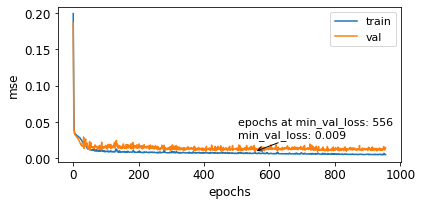

In [72]:

# =============================================================================

# =============================================================================
# =============================================================================
# Define model
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
# =============================================================================
opt = Adam(learning_rate = 0.0009, clipnorm = 1.00)
model.compile(optimizer=opt, loss='mse')
callbacks_list = [
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=400,
mode="min",
),
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+str(k)+"lead"+str(m)+"best_stop.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
)
]

model.compile(optimizer=Adam(learning_rate = 0.00095, clipnorm = 1.001),
loss="mse",
metrics=["mse"])
# Fit model

history1=model.fit(train_X,
          y_train_scale,
epochs=1500,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale))
# =============================================================================
# # Save loss values
# with open(outs[1]+'/'+str(k)+'lead'+str(m)+'T3_lag3loss.csv', 'wb') as f1: # khong nen
#   # compressed_file = bz2.BZ2File(f, 'w')
#     w = csv.DictWriter(f1, history1.history.keys())
#     w.writeheader()
#     w.writerow(history1)

# # #####
# ## mo kiem tra lai
# with open(outs[1]+'/'+str(k)+'lead'+str(m)+'T3_lag3loss.csv', 'rb') as f2: # khong nen
#     # compressed_file = bz2.BZ2File(f, 'r')
#     load_history1 = csv.DictReader(f2)
# # 0,1,2 tuong ung voi train, val, test
# # pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# # print('cc of val: '+str(pearson))
# =============================================================================
# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+str(k)+"lead"+str(m)+"best_stop.keras")
print("Loaded model from disk")

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# ve learning rate to load model
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history1.history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)

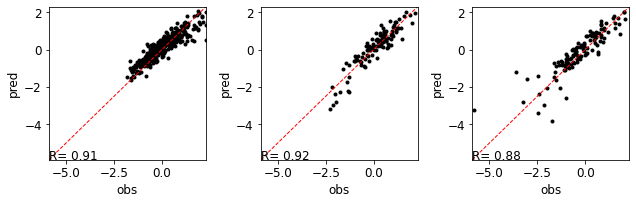

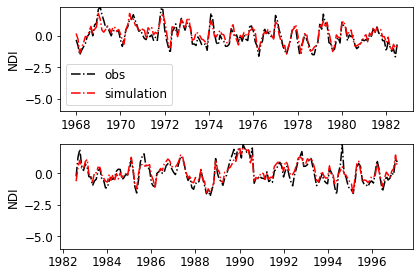

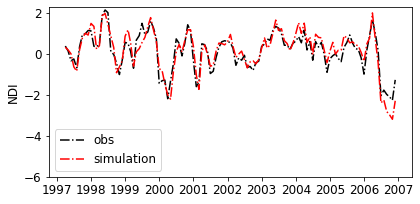

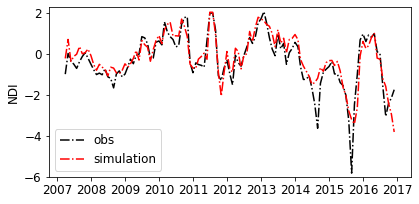

In [73]:

#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# LUU LAI KET QUA
# =============================================================================
with open(outs[1]+'/'+str(k)+'lead'+str(m)+'T3_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+str(k)+'lead'+str(m)+'T3_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2
  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    # fig,ax=plt.subplots(figsize=(5,5))
    # min_values1=np.min([pred_all[m],obs_all[m]])
    # min_values=min_values1
    # max_values1=np.max([pred_all[m],obs_all[m]])
    # max_values=max_values1
    min_values=-5.9
    max_values=2.29

    plt.xlim(min_values,max_values)
    plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T3'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve train
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  # plt.plot(vector_date[n_in0+lead_time:n_train-n_out0+lead_time+1], obs1[n_in0+lead_time:n_train-n_out0+lead_time+1,lead_time], 'k-.')
  # plt.plot(vector_date[n_in0+lead_time:n_train+-n_out0+lead_time+1], pred1[:,lead_time], 'r-.')
  
  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  
  
  
  # plt.plot(vector_date[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)]+lead_time-n_out0+1, pred[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)+lead_time-n_out0+1,lead_time],'r-.')
  # plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T3'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')

  # plt.plot(vector_date[n_in0+lead_time:n_train-n_out0+lead_time+1], obs1[n_in0+lead_time:n_train-n_out0+lead_time+1,lead_time], 'k-.')
  # plt.plot(vector_date[n_in0+lead_time:n_train+-n_out0+lead_time+1], pred1[:,lead_time], 'r-.')
  
  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at validation')
  plt.tight_layout()

  # plt.subplot(212)
  # plt.rcParams.update({'font.size': 12})
  # plt.plot(vector_date[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)+lead_time-n_out0+1], 
  #          obs[int(dataset0.shape[0]*0.3)+input:int(dataset0.shape[0]*0.6)+lead_time-n_out0+1,lead_time], 'k-.')
  
  # plt.plot(vector_date[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)]+lead_time-n_out0+1, pred[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)+lead_time-n_out0+1,lead_time],'r-.')
  # plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'val_time_T3'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # Testing
  
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6.0,2.3])
  vector_date_test=vector_date[-24:]
  # plt.plot(vector_date[n_train+n_val+lead_time:n_train+n_val+n_test+lead_time+obs3.shape[0]],obs3[:,lead_time],'k-.')
  # plt.plot(vector_date[n_train+n_val+lead_time:n_train+n_val+lead_time+n_test+obs3.shape[0]],pred3[:,lead_time],'r-.')
  plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
  plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
  # plt.plot(vector_date[n_in0+lead_time:n_train-n_out0+lead_time+1], obs1[n_in0+lead_time:n_train-n_out0+lead_time+1,lead_time], 'k-.')
  # plt.plot(vector_date[n_in0+lead_time:n_train+-n_out0+lead_time+1], pred1[:,lead_time], 'r-.')
  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1month' +' lead time prediction at testing')
  plt.tight_layout()

  # plt.subplot(212)
  # plt.rcParams.update({'font.size': 12})
  # plt.plot(vector_date[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)+lead_time-n_out0+1], 
  #          obs[int(dataset0.shape[0]*0.3)+input:int(dataset0.shape[0]*0.6)+lead_time-n_out0+1,lead_time], 'k-.')
  
  # plt.plot(vector_date[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)]+lead_time-n_out0+1, pred[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)+lead_time-n_out0+1,lead_time],'r-.')
  # plt.legend(['obs','simulation'])

  # plt.ylabel('NDI')
  # plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'test_time_T3'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
